# The following Block is uncommented for running on Google Colab

In [20]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# # enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment3/'
# FOLDERNAME = 'comp451/Project/visual-transformer'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# import os
# sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# ROOT_PATH = PATH = '/content/drive/MyDrive/comp451/Project/visual-transformer'

# os.chdir(ROOT_PATH)


In [21]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [1]:
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Subset
from torchvision import models
from models.vt_resnet20 import VTResNet20
from models.resnet import BasicBlock
import matplotlib.pyplot as plt
import random
import pickle
import PIL
import numpy as np
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

from models.vt_resnet import vt_resnet18

In [23]:
# clean visualization directory

!rm -rf ./vizlogs/

In [2]:
def random_seed():
    np.random.seed(8)
    torch.manual_seed(8)
    random.seed(8)

In [3]:
def store_params(content, name):
    f = open("params/" + name + ".pkl","wb")
    pickle.dump(content, f)
    f.close()

def load_params(name):
    fl = open("params/" + name + ".pkl", "rb")
    loaded = pickle.load(fl)
    return loaded

In [4]:
def show_image(img, one_channel=False, fig=(10,10), title='No Title'):
    if one_channel:
        img = img.mean(dim=0)
    img = img * 0.225 + 0.456     # unnormalize
    npimg = img.numpy()
    if one_channel:
        
        plt.figure(figsize = fig)
        plt.title(title)
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [27]:
def get_data(name, valid_norm=True):

    transform_train = torchvision.transforms.Compose(
     [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    transform_valid = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    if valid_norm == False:
        transform_valid = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ])

    if name == 'CIFAR10':
        data_train = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=transform_train)
        data_valid = torchvision.datasets.CIFAR10('/data', train=False, download=True, transform=transform_valid)

        return data_train, data_valid
    
    if name == 'MNIST':
        data_train = torchvision.datasets.MNIST('/data', train=True, download=True, transform=transform_train)
        data_valid = torchvision.datasets.MNIST('/data', train=False, download=True, transform=transform_valid)

        return data_train, data_valid

    if name == 'ImageNet':
        data_train = torchvision.datasets.ImageNet('/content/drive/MyDrive/comp451/Project/visual-transformer/data', split='train', transform=transform_train)
        data_valid = torchvision.datasets.ImageNet('/content/drive/MyDrive/comp451/Project/visual-transformer/data', split='val', transform=transform_valid)

        return data_train, data_valid

In [28]:
data_train, data_valid = get_data('CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


In [29]:
classes = {
    0: 'airplane',										
    1: 'automobile',									
    2: 'bird'	,									
    3: 'cat'	,									
    4: 'deer'	,									
    5: 'dog'	,									
    6: 'frog'	,									
    7: 'horse',										
    8: 'ship'	,									
    9: 'truck',
}

In [30]:
train_loader = DataLoader(data_train, batch_size=1, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=1, shuffle=False)

In [31]:
_, orig_valid_data = get_data('CIFAR10', valid_norm=False)
orig_loader = DataLoader(data_valid, batch_size=1, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# This cell is used to load the model from which visualization are to be extracted

For loading the model with k tokens assign k to the variable `chosen_model`. The available token choices currently are [4, 6, 8]

In [8]:

chosen_model = 4


##################################################
L = 8
D = 512
layer_plane = [64, 128, 256, 512]
enc_layer = 2
n_heads = 8
vt_channels = 128
fc_dim = 512
dropout = 0.5
vt_num_layers = 1
input_dim = 32

translate = {
    4:8,
    6:12,
    8:11,
}

params = load_params('param_c_10_lr_002')


model = vt_resnet18(
    tokens=params['L'],
    token_channels=params['D'],
    input_dim=input_dim,
    vt_channels=params['vt_channels'],
    transformer_enc_layers=params['enc_layer'],
    transformer_heads=params['n_head'],
    transformer_fc_dim=params['fc_dim'],
    transformer_dropout=params['dropout'],
    image_channels=3,
    num_classes=10,
)
 
model.load_state_dict(torch.load('trained_models/model_c_10_lr_002.pth', map_location=torch.device('cpu')))
model.eval()
print(params)

{'valid_acc': tensor(86.), 'train_acc': tensor(96.7160), 'lr': 0.002, 'L': 16, 'N': 128, 'D': 1024, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 1024, 'vt_channels': 512, 'dropout': 0.5, 'n_head': 1, 'vt_num_layer': 2}


In [34]:
by_class = {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[],
    5:[],
    6:[],
    7:[],
    8:[],
    9:[],
}

img_orig = {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[],
    5:[],
    6:[],
    7:[],
    8:[],
    9:[],
}

for i in valid_loader:
    im, l = i
    by_class[l.item()].append(im)
for i in orig_loader:
    im, l = i
    img_orig[l.item()].append(im)

# Choosing an image for visualization

In order to choose images to visualize, you need assign numbers to the variables `k` and `i`. `k` represents which class you want the images from, so it takes values from 0 to 9 inclusive. `i` represents the index of the image to be chosen from class `k`. The images in each class are ordered according the loaded order from torchvision, and it is consistent accross different runs of this notebook. Note that with setting only test set images can be visualized.

horse


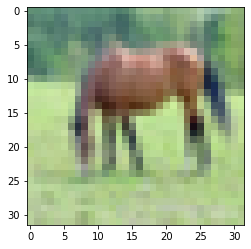

In [35]:
k = 7
i = 6

##################################################
res = model(by_class[k][i])
show_image(torchvision.utils.make_grid(by_class[k][i]))
print(classes[k])

# After running the previous cell, run this cell below to produce the visualizations.

horse


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


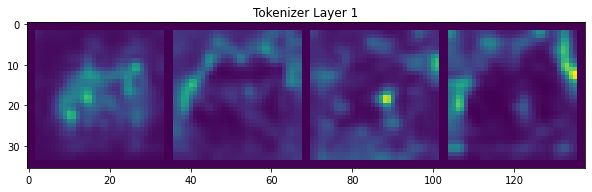

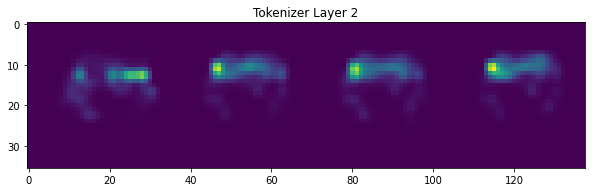

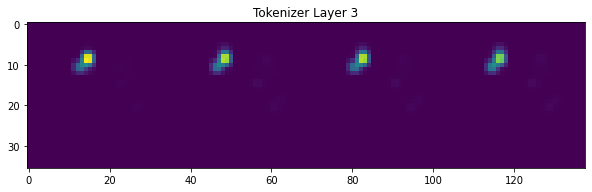

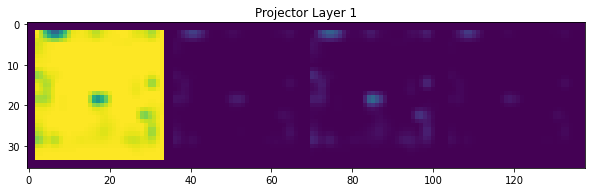

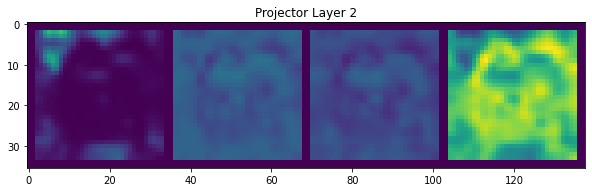

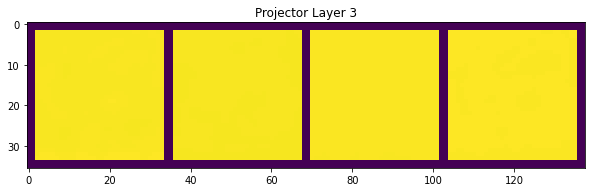

In [36]:
output = F.log_softmax(res, dim=1)
_, pred = torch.max(output, dim=1)
print(classes[pred.item()])

for i in range(params['vt_num_layer']):
    cache = model.vt_layers[i].tokenizer.cache2
    cache = torch.transpose(cache, 1, 2)
    with torch.no_grad():
        pic = cache[0].reshape(params['L'], 1, 16, 16)
        pic = F.interpolate(pic, scale_factor=2, mode='bilinear')
        show_image(torchvision.utils.make_grid(pic, nrow=4), True, fig=(10,10), title='Tokenizer Layer ' + str(i + 1))

pr_cache1 = model.vt_layers[0].projector.cache
pr_cache2 = model.vt_layers[1].projector.cache
pr_cache3 = model.vt_layers[2].projector.cache
pr_cache1 = torch.transpose(pr_cache1, 1, 2)
pr_cache1 = torch.transpose(pr_cache1, 0, 1)
pr_cache2 = torch.transpose(pr_cache2, 1, 2)
pr_cache2 = torch.transpose(pr_cache2, 0, 1)
pr_cache3 = torch.transpose(pr_cache3, 1, 2)
pr_cache3 = torch.transpose(pr_cache3, 0, 1)

with torch.no_grad():
    pic = pr_cache1.reshape(params['L'], 1, 16, 16)
    pic = F.interpolate(pic, scale_factor=2, mode='bilinear')
    show_image(torchvision.utils.make_grid(pic, nrow=4), True, fig=(10,10), title='Projector Layer 1')

with torch.no_grad():
    pic = pr_cache2.reshape(params['L'], 1, 16, 16)
    pic = F.interpolate(pic, scale_factor=2, mode='bilinear')
    show_image(torchvision.utils.make_grid(pic, nrow=4), True, fig=(10,10), title='Projector Layer 2')

with torch.no_grad():
    pic = pr_cache3.reshape(params['L'], 1, 16, 16)
    pic = F.interpolate(pic, scale_factor=2, mode='bilinear')
    show_image(torchvision.utils.make_grid(pic, nrow=4), True, fig=(10,10), title='Projector Layer 3')

In [ ]:
%tensorboard --logdir vizlogs